In [1]:
import numpy as np 
import pandas as pd 
import os
import gc
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from tqdm.autonotebook import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import keras.backend as K
from keras.models import Sequential
from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model

C:\Users\c\AppData\Local\Temp/ipykernel_14240/1065514822.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
train_df = pd.read_csv("train.csv")
train_df.head()
print(train_df.shape)

(51033, 3)


In [3]:
def Loading_Images(data, m):
    print("Loading images")
    X_train = np.zeros((m, 512, 512 , 3))
    count = 0
    for fig in tqdm(data['image']):
        img = image.load_img('train_images/' + fig, target_size = (512, 512, 3))        # 512의 메모리가 할당되지 않으므로,.
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X_train[count] = x
        count += 1
    return X_train

def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse = False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded
    return y, label_encoder

In [4]:
X = Loading_Images(train_df, train_df.shape[0])
X /= 255.0

Loading images


MemoryError: Unable to allocate 299. GiB for an array with shape (51033, 512, 512, 3) and data type float64

In [36]:
y, label_encoder = prepare_labels(train_df['individual_id'])

In [37]:
y.shape
gc.collect()

7318

In [38]:
model = Sequential()

model.add(Conv2D(32, (3, 3), strides = (1, 1), input_shape = (32, 32, 3)))
model.add(BatchNormalization(axis = 3))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), strides = (1,1)))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3)))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 13, 13, 64)        0

In [39]:
history = model.fit(X, y, epochs=150, batch_size=128, verbose=1)
model.save('./last.h5')

Epoch 1/150
399/399 [==============================] - 11s 14ms/step - loss: 8.5015 - accuracy: 0.0098
Epoch 2/150
399/399 [==============================] - 5s 14ms/step - loss: 7.6381 - accuracy: 0.0172
Epoch 3/150
399/399 [==============================] - 5s 14ms/step - loss: 7.0881 - accuracy: 0.0243
Epoch 4/150
399/399 [==============================] - 6s 14ms/step - loss: 6.5199 - accuracy: 0.0352
Epoch 5/150
399/399 [==============================] - 6s 14ms/step - loss: 5.9165 - accuracy: 0.0492
Epoch 6/150
399/399 [==============================] - 5s 14ms/step - loss: 5.2719 - accuracy: 0.0767
Epoch 7/150
399/399 [==============================] - 5s 14ms/step - loss: 4.6411 - accuracy: 0.1221
Epoch 8/150
399/399 [==============================] - 5s 14ms/step - loss: 4.0425 - accuracy: 0.1870
Epoch 9/150
399/399 [==============================] - 5s 14ms/step - loss: 3.5447 - accuracy: 0.2590
Epoch 10/150
399/399 [==============================] - 5s 14ms/step - loss: 3.14

In [40]:
del X
del y
gc.collect()

994

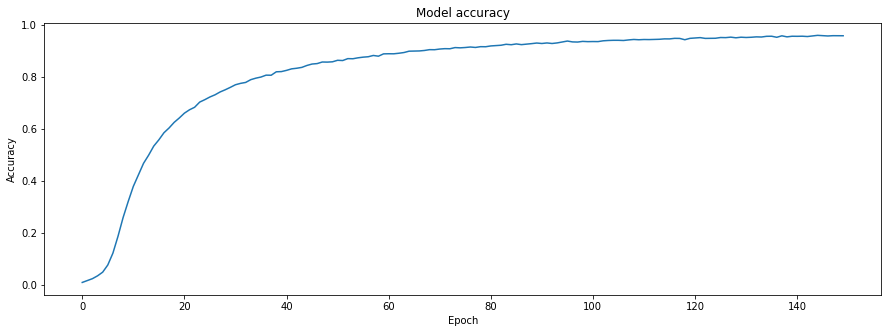

In [41]:
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

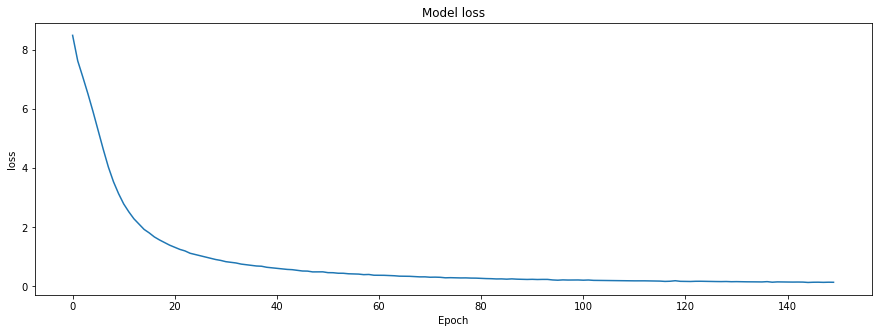

In [43]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [45]:
import os
test = os.listdir('test_images')
print(len(test))

col = ['image']
test_df = pd.DataFrame(test, columns=col)
test_df['predictions'] = ''

27956


In [58]:
batch_size=5000
batch_start = 0
batch_end = batch_size
L = len(test_df)

while batch_start < L:
    limit = min(batch_end, L)
    test_df_batch = test_df.iloc[batch_start:limit]
#     print(type(test_df_batch))
    X = Loading_Images(test_df_batch, test_df_batch.shape[0])
    X /= 255
    predictions = model.predict(np.array(X), verbose=1)
#     print('prediction shape :  ', predictions.shape)
    for i, pred in enumerate(predictions):
        print('pred shape :  ',  pred.shape)
        p=pred.argsort()[-4:][::-1]
#         print(p)
        idx=-1
        s=''
        s1=''
        s2=''
        for x in p:
            idx=idx+1
            if pred[x]>0.5:
                s1 = s1 + ' ' + label_encoder.inverse_transform(p)[idx]
            else:
                s2 = s2 + ' ' + label_encoder.inverse_transform(p)[idx]
        s= s1 + ' new_individual' + s2
        s = s.strip(' ')
        test_df.loc[ batch_start + i, 'predictions'] = s
    batch_start += batch_size   
    batch_end += batch_size
    del X
    del test_df_batch
    del predictions
    gc.collect()

Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 0s 988us/step
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred sh

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 0s 1ms/step
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shap

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 0s 982us/step
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred sh

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 0s 991us/step
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred sh

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 0s 1ms/step
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shap

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

  0%|          | 0/2956 [00:00<?, ?it/s]

93/93 [==============================] - 0s 1ms/step
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape 

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (15587,)
pred shape :   (

In [59]:
test_df.to_csv('submission.csv',index=False)
test_df.head()

,image,predictions
0,000110707af0ba.jpg,6e3655e22f38 new_individual a614fcce14b3 93a3c...
1,0006287ec424cb.jpg,f1e6c5118903 new_individual 7ec7661599f8 fdee4...
2,000809ecb2ccad.jpg,new_individual 6da7ae3c5d54 124534ac8131 a52e4...
3,00098d1376dab2.jpg,49f9246ea28b new_individual be3543fc7c74 09141...
4,000b8d89c738bd.jpg,26a096a6ab99 new_individual 842e85d5d69f ef2bf...


In [60]:
test_df.iloc[:, 1][0]

'6e3655e22f38 new_individual a614fcce14b3 93a3cb74801f be330f0c495c'